In [61]:
using LinearAlgebra, Plots, PlotThemes, LaTeXStrings; theme(:dao)

In [62]:
# define problem parameters
ħ = 1.0;
m = 1.0;
V₁ = 5.0;
σᵥ = 1;
V(x) = 0#V₁ * x^2;
nPts=800;
L = 10;
Δx = L/(nPts-1);
x=collect((-L/2):Δx:(L/2));
Vx = V.(x);
# Define quantum operators:
∇² =Δx^(-2)*SymTridiagonal(-2ones(nPts),ones(nPts-1)); #Discrete Laplacian
V̂ = Diagonal(Vx);
# H₀ = (-ħ^2/(2m))∇²; # Hamiltonian w/ no barrier
H = (-ħ^2/(2m))∇² + V̂; # Hamiltonian 

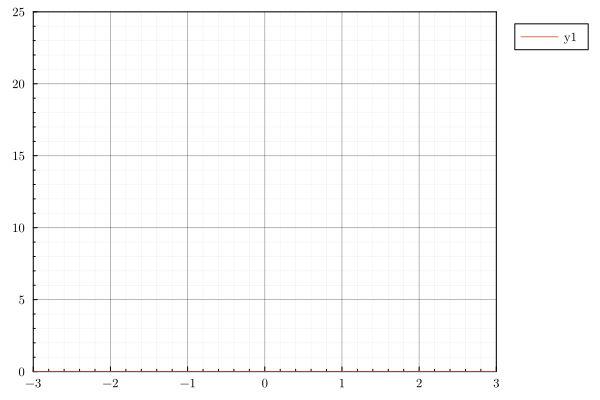

In [63]:
plot(x[abs.(x) .< 3],Vx[abs.(x) .< 3],xlim=(-3,3),ylim=(0,5V₁))

In [64]:
eigs = eigen(H);

In [65]:
# ℰs, ψs = eigen(H);
# ψs = 
ℰs = eigs.values;
ψs = eigs.vectors .* Δx^(-1/2);

In [66]:
σₓ₀ = σᵥ/3.0;
x₀ = -0.1;
p₀ = 0.00;
ψ₀ = normalize(exp.(-(x .- x₀).^2 ./(4 * σₓ₀^2) + 1.0im * p₀ * x /ħ)) .* Δx^(-1/2);

In [67]:
# convert to stationary state basis
ψ₀eigenbasis = ψs' * ψ₀;

In [68]:
ψ(t) = ψs * Diagonal(exp.(-1.0im * t*ℰs/ħ )) * ψ₀eigenbasis * Δx;

In [1]:
plot(x[abs.(x) .< 6],(abs.(ψ(100.0rand())).^2)[abs.(x) .< 6],xlim=(-6,6),ylim=(0,1))


UndefVarError: UndefVarError: x not defined

In [70]:
Δt = m*Δx^2 / ħ;
∂ₜψ(t,hₜ) = (ψ(t+hₜ) - ψ(t-hₜ))/(2hₜ);

In [71]:
TDSE(t,hₜ) = ∂ₜψ(t,hₜ) + (1.0im*ħ/m)*H *ψ(t);
TDSE(t) = TDSE(t,eps()^(1/3));

In [72]:
norm(TDSE(1.0))

7.961900794525484e-9

In [73]:
# norm(TDSE(1.0))
# ψ(0.0)

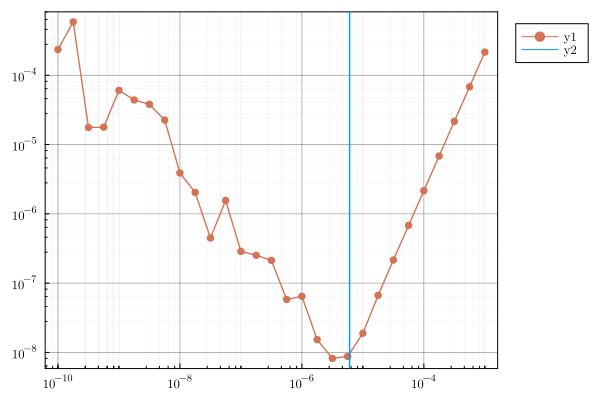

In [74]:
let hs = 10.0.^(-10:0.25:-3)
    plot(hs,(hₜ->norm(TDSE(100rand(),hₜ))).(hs),xscale=:log10,yscale=:log10,marker=:circle)
    vline!([eps()^(1/3)])
end

In [75]:
using Flux

In [227]:
ψNN = Chain(
    Dense(2 => 1200,relu),
    Dense(1200 => 800,relu),
    Dense(800 => 400,relu),
    Dense(400 => 400,relu),
    Dense(400 => 400,relu),
    Dense(400 => 2,identity),
    X -> X[1] + 1.0im*X[2]
)

Chain(
  Dense(2 => 1200, relu),               # 3_600 parameters
  Dense(1200 => 800, relu),             # 960_800 parameters
  Dense(800 => 400, relu),              # 320_400 parameters
  Dense(400 => 400, relu),              # 160_400 parameters
  Dense(400 => 400, relu),              # 160_400 parameters
  Dense(400 => 2),                      # 802 parameters
  var"#101#102"(),
)                   # Total: 12 arrays, 1_606_402 parameters, 6.129 MiB.

In [228]:
x∂ = -5:0.05:5;

In [229]:
ψ₀init(x) = (sqrt(2/10)*cos.(π*x/10) .+ sqrt(2/10)*sin.(2π*x/10))/sqrt(2) |> ComplexF64;

In [230]:
loss(hcat(x∂,zeros(size(x∂))),ψ₀init.(x∂))


10.491793906600053

In [231]:
datx = vcat(hcat(x∂,zeros(size(x∂))),hcat(-5ones(10),10rand(10)),hcat(5ones(10),10rand(10)));
daty = vcat(ψ₀init.(x∂),zeros(10),zeros(10));

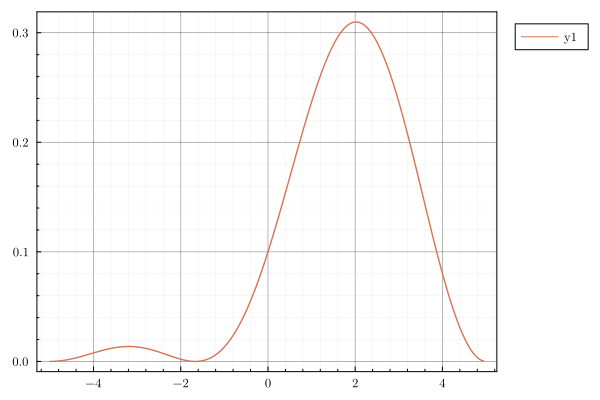

In [232]:
plot(datx[1:200,1],abs.(daty[1:200]).^2)

In [233]:
using Statistics

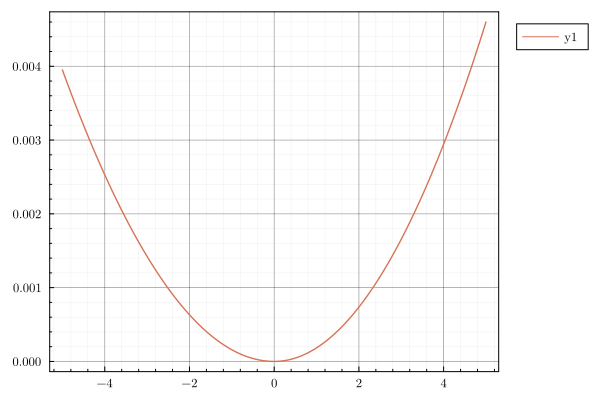

In [234]:
plot(-5:0.05:5,abs.(ψNN.(eachrow(hcat(collect(-5:0.05:5),0.0ones(size(-5:0.05:5)))))).^2)

In [235]:
evalPDElocs = vcat(((X -> hcat(collect(-5:0.05:5), X*ones(size(-5:0.05:5)))).(0:0.05:10))...);

In [236]:
function loss(x,y)
    bdcds = mean(abs.(y  .- ψNN.(eachrow(x))).^2);
    ∂ₓ²ψ(x,t,hₓ) = (ψNN([x+hₓ,t])-2ψNN([x,t])+ ψNN([x-hₓ,t]))/(hₓ^2);
    ∂ₜψ(x,t,hₜ) = (ψNN([x,t+hₜ]) - ψNN([x,t-hₜ]))/(2hₜ);
    TDSE(xt,hₓ,hₜ) = 1.0im*ħ*∂ₜψ(xt[1],xt[2],hₜ) + (ħ^2/2m)*∂ₓ²ψ(xt[1],xt[2],hₓ);
    evalPDElocs = vcat([hcat(10.0.*(rand(20).-0.5),10rand(20)) for _ in 1:20]...);
    TDSEloss = mean((X -> norm(TDSE(X,eps()^(1/3),eps()^(1/3)))^2).(eachrow(evalPDElocs)));
    return 100.0bdcds + 0.0TDSEloss
end

loss (generic function with 1 method)

In [237]:
opt = Adam(0.03)

Adam(0.03, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [238]:
pars= Flux.params(ψNN);

In [239]:
data=[(datx,daty)];

In [240]:
for _ in 1:10
    Flux.train!(loss,pars,data,opt)
end

In [241]:
loss(datx,daty)

105.81669786358839

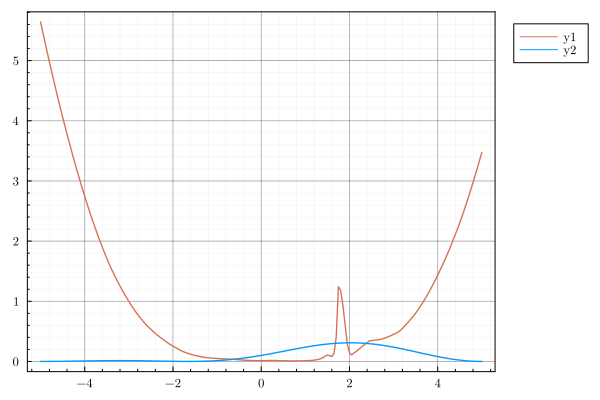

In [242]:
plot(-5:0.05:5,abs.(ψNN.(eachrow(hcat(collect(-5:0.05:5),0.0ones(size(-5:0.05:5)))))).^2)
plot!(-5:0.05:5,abs.(ψ₀init.(-5:0.05:5)).^2)

In [18]:
ψ₀ = (sqrt(2/10)*cos.(π*x∂/10) .+ sqrt(2/10)*sin.(2π*x∂/10))/sqrt(2);

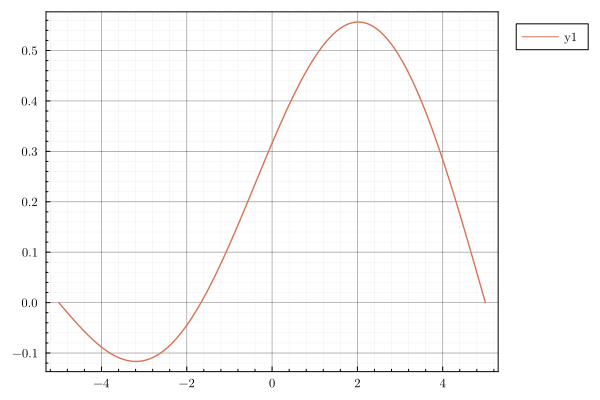

In [19]:
# plot((x -> abs(ψNN([x,0.0]))^2).(-5:0.05:5))
plot(x∂,ψ₀)

In [20]:
bcsx = vcat(hcat(x∂,zeros(size(x∂))),hcat(5ones(80),30rand(80)),hcat(-5ones(80),30rand(80)));

In [21]:
bcsy = ComplexF64.(vcat(ψ₀,zeros(80),zeros(80)));

In [26]:
loss = ψNN.(eachrow(bcsx)) - bcsy

361-element Vector{ComplexF64}:
  -0.002913979138221365 + 0.02894139412986825im
  0.0016257017826263815 + 0.028658626195243522im
   0.006171282189282668 + 0.028380768341652218im
   0.010714133733258182 + 0.02810759297244146im
   0.015245640928411084 + 0.027838873130146224im
   0.019757210560919017 + 0.027574382642548367im
    0.02424028107419153 + 0.027313896271588717im
   0.028686331919166995 + 0.027057189864832114im
    0.03308689286048752 + 0.02680404050918149im
    0.03743355322907965 + 0.026554226686501113im
                        ⋮
    -1.3006209796801818 + 0.41554274338131597im
 -0.0036147987266291724 + 0.06435520661187473im
     -1.033595318451422 + 0.32385344922267617im
    -1.1226843855238033 + 0.3492675574776388im
   -0.24503900403787537 + 0.21355628695267953im
 -0.0029267966352029794 + 0.05425374261986375im
    -1.2847555449580867 + 0.4087035240057733im
  -0.038611804394496504 + 0.13716880008448856im
     -1.088130396977536 + 0.3388901555121683im

In [22]:
data = Flux.DataLoader((bcsx,bcsy),batchsize=200);

In [46]:
pars = Flux.params(ψNN);

In [47]:
opt = Flux.Adam(0.01)

Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [57]:
# ψNN.(eachrow(data))
loss(x,y) = abs(ψNN(x) -y )^2

loss (generic function with 1 method)

In [62]:
# loss(rand(eachrow(bcsx)),bcsy[1])

ArgumentError: ArgumentError: Sampler for this object is not defined

In [58]:
for epoch in 1:1_000
    Flux.train!(loss,pars, data, opt)
end

DimensionMismatch: DimensionMismatch: All data containers must have the same number of observations.